# Fine-tuning BERT on SQuAD Dataset for Question Answering with LexPilot

This notebook demonstrates how to fine-tune the BERT model on the Stanford Question Answering Dataset (SQuAD) for extractive question answering as part of the **LexPilot** project.

We will cover:

1. Installing and importing necessary libraries  
2. Loading and exploring the SQuAD dataset  
3. Tokenizing and preparing features  
4. Creating PyTorch datasets and dataloaders  
5. Loading and fine-tuning BERT for question answering  
6. Saving the fine-tuned model and embeddings  
7. Defining a prediction function to answer questions  
8. Visualizing token embedding similarities using a cosine similarity heatmap  

---

## 1. Install and Import Required Packages

LexPilot uses Hugging Face transformers and datasets libraries, along with PyTorch and visualization tools.


In [ ]:
!pip uninstall -y torch torchvision torchaudio transformers protobuf websockets gradio sentence-transformers yfinance


Found existing installation: torch 2.1.2+cu121
Uninstalling torch-2.1.2+cu121:
  Successfully uninstalled torch-2.1.2+cu121
Found existing installation: torchvision 0.16.2+cu121
Uninstalling torchvision-0.16.2+cu121:
  Successfully uninstalled torchvision-0.16.2+cu121
Found existing installation: torchaudio 2.1.2+cu121
Uninstalling torchaudio-2.1.2+cu121:
  Successfully uninstalled torchaudio-2.1.2+cu121
Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
Found existing installation: protobuf 5.26.1
Uninstalling protobuf-5.26.1:
  Successfully uninstalled protobuf-5.26.1
Found existing installation: websockets 11.0.3
Uninstalling websockets-11.0.3:
  Successfully uninstalled websockets-11.0.3
Found existing installation: gradio 4.31.4
Uninstalling gradio-4.31.4:
  Successfully uninstalled gradio-4.31.4
Found existing installation: sentence-transformers 2.7.0
Uninstalling sentence-transformers-2.7.0:
  Success

In [ ]:
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 \
transformers==4.39.3 sentence-transformers==2.6.1 \
protobuf==5.26.1 websockets==11.0.3 gradio==4.15.0 yfinance==0.2.36 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 256.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 30.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.20.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 11.0.3 which is incompatible.
dataproc-spark-connect 0.7.5 requires websockets>=14.0, but you have websockets 11.0.3 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 5.26.1 which is incompatible.




### Key Notes:

- **prepare_features:** Tokenizes and aligns start/end positions for answers.  
- **QADataset:** Custom PyTorch dataset for QA task.  
- **Training loop:** Runs multiple epochs, optimizing model weights.  
- **Saving:** Model weights saved as `lexpilot_trained_model.pt`, embeddings saved as `lexpilot_word_embeddings.pt`.  
- **Download links:** Displayed for easy download in notebook environments (e.g., Google Colab).  
- **answer_question:** Predict answer for a given question and context using the trained LexPilot model.  


In [ ]:
# Import required libraries
from datasets import load_dataset
from transformers import BertTokenizerFast, BertForQuestionAnswering
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


# 2. Load the SQuAD Dataset
We load the SQuAD dataset and extract smaller subsets for faster experimentation in LexPilot.

In [ ]:
# ----------------------------
# 1. LOAD DATASET (SQuAD)
# ----------------------------
from datasets import load_dataset
dataset = load_dataset("squad")
print(dataset)


# Select smaller subset for quicker training
small_train = dataset["train"].select(range(2000))
small_val = dataset["validation"].select(range(500))
print(small_train[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})
{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome

### Understanding the Dataset

The dataset consists of pairs of **questions** and corresponding **context** passages, along with the **answers** and their start positions within the context. Each example includes:

- **question:** The question we want the model to answer.
- **context:** A passage of text that contains the answer.
- **answers:** The actual answer text and the character index where the answer starts in the context.

This structure is essential for training a Question Answering model, which learns to locate the exact span of text in the context that answers the question. Examining the dataset helps ensure that the data is correctly formatted and that the answers align properly within the contexts.


# 3. Tokenization and Feature Preparation
LexPilot tokenizes question-context pairs with BERT tokenizer. Sliding windows with overlaps handle long contexts, and answer spans are mapped to token positions for training.



In [ ]:
# Load BERT tokenizer (uncased)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def prepare_features(examples):
    # Tokenize with sliding window to handle long contexts
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized_examples.sequence_ids(i)
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        # No answer case
        if len(answers["answer_start"]) == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # Check if answer is in current span
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                # Find token start position
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                start_positions.append(token_start_index - 1)

                # Find token end position
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                end_positions.append(token_end_index + 1)

    tokenized_examples["start_positions"] = start_positions
    tokenized_examples["end_positions"] = end_positions

    return tokenized_examples

# Apply tokenization and feature preparation to subsets
tokenized_train = small_train.map(prepare_features, batched=True, remove_columns=small_train.column_names)
tokenized_val = small_val.map(prepare_features, batched=True, remove_columns=small_val.column_names)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

### Preparing Tokenized Features with Answer Positions

This function tokenizes each question-context pair, handling long contexts with a sliding window approach. It aligns character-based answer spans to token indices, which is essential because the model needs to learn to predict the start and end token positions of the answer within the input tokens. If an example has no answer, the positions default to the CLS token index, a standard practice for no-answer cases. This preprocessing prepares our dataset for training the question answering model.


# 4. Create PyTorch Dataset and DataLoader
We prepare datasets and dataloaders for LexPilot's training and validation.

In [ ]:
class QADataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "start_positions": torch.tensor(self.encodings["start_positions"][idx]),
            "end_positions": torch.tensor(self.encodings["end_positions"][idx]),
        }

# Instantiate datasets for training and validation
train_dataset = QADataset(tokenized_train)
val_dataset = QADataset(tokenized_val)

# Create dataloaders with batching
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


### Creating Dataset and DataLoader for PyTorch

PyTorch models work with tensors and benefit from batched data input. The `QADataset` class wraps our tokenized data and converts all features into tensors. The DataLoader creates batches and shuffles data during training to improve learning efficiency and generalization. This setup allows efficient feeding of data to the model during training and evaluation.


# 5. Load Pretrained BERT QA Model and Train LexPilot
We load the BERT QA model, fine-tune for 2 epochs with AdamW optimizer, and print training progress.

In [ ]:
import torch
from transformers import BertForQuestionAnswering
from torch.optim import AdamW
from tqdm import tqdm

# ----------------------------
# 1. Set Device (GPU if available)
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔍 Using device: {device}")

# ----------------------------
# 2. Load BERT Model
# ----------------------------
try:
    model = BertForQuestionAnswering.from_pretrained("bert-base-uncased").to(device)
except ImportError as e:
    print("❌ PyTorch must be installed to use this model. Error:", e)
    raise

# ----------------------------
# 3. Setup Optimizer
# ----------------------------
optimizer = AdamW(model.parameters(), lr=3e-5)

# ----------------------------
# 4. Training Loop
# ----------------------------
model.train()
epochs = 2

for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1} - LexPilot Training")

    for batch in loop:
        # Move batch to the right device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            start_positions=start_positions,
            end_positions=end_positions
        )

        # Backpropagation
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # Logging
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} Average Loss: {avg_loss:.4f}")


🔍 Using device: cuda


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1 - LexPilot Training: 100%|██████████| 257/257 [27:05<00:00,  6.32s/it, loss=2.06]


✅ Epoch 1 Average Loss: 3.3855


Epoch 2 - LexPilot Training: 100%|██████████| 257/257 [26:56<00:00,  6.29s/it, loss=1.64]


✅ Epoch 2 Average Loss: 1.4580


### 🧾 Training Output Explanation

---

#### ⚠️ Warning Message  
**"Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']"**

- This is **not an error**, but an **informative message**.
- It indicates that the QA-specific output layer (`qa_outputs`) wasn’t part of the original BERT model and was **randomly initialized**.
- BERT is pretrained on general text, not QA, so this final layer needs to be **fine-tuned** on your custom dataset.
- ✔️ Training on SQuAD (or other QA tasks) will adapt these weights accordingly.

---

#### 📉 Epoch-wise Training Results

---

✅ **Epoch 1**  
- **Progress:** `100%` complete  
- **Time Taken:** ~27 minutes  
- **Final Batch Loss:** `2.06`  
- **Average Loss for Epoch 1:** `3.3855`  
  - The model is beginning to learn patterns, but still makes large errors at this stage.

---

✅ **Epoch 2**  
- **Progress:** `100%` complete  
- **Time Taken:** ~27 minutes  
- **Final Batch Loss:** `1.64`  
- **Average Loss for Epoch 2:** `1.4580`  
  - Significant improvement observed — the model is clearly adapting to the task.
  - Lower loss indicates **better alignment between predictions and true answer spans**.

---

#### 📌 What Does "Loss" Mean?

- **Loss** quantifies the difference between the model's predictions and the actual answers.
- The objective during training is to **minimize loss**.
- A high loss ~3.38 suggests the model is unsure or incorrect, while a lower loss ~1.45 indicates **learning progress**.

---

#### 📊 Conclusion

- Your model is successfully fine-tuning on the QA dataset.
- The initial warning about uninitialized weights is expected and handled during training.
- A significant drop in loss from Epoch 1 to Epoch 2 shows that **LexPilot is learning effectively**.
- You’re now ready to use the trained model for **inference and confidence scoring**.


### Loading Pretrained BERT Model and Optimizer

We load the BERT model specifically designed for question answering, which can predict start and end tokens for answers. The model is moved to GPU if available for faster training. The AdamW optimizer is chosen with a small learning rate suitable for fine-tuning transformer models. This prepares the model and optimizer for the training process.


### Training Loop for Fine-tuning the Model

This loop iterates through training batches, feeding inputs to the model and calculating loss based on predicted vs actual answer spans. The loss is backpropagated to update the model weights. We use a progress bar to monitor training and print average loss after each epoch. Training for multiple epochs allows the model to learn how to accurately predict answer positions.


# 6. Save the Fine-Tuned Model and Embeddings
We save LexPilot's trained model and a sample embedding tensor for further analysis or deployment.

In [ ]:
# Save the fine-tuned model weights
torch.save(model.state_dict(), "lexpilot_trained_model.pt")

# Extract word embeddings from a sample batch
model.eval()
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    input_ids = sample_batch["input_ids"].to(device)
    embeddings = model.bert.embeddings.word_embeddings(input_ids).cpu()
    torch.save(embeddings, "lexpilot_embeddings_tensor.pt")


### Saving the Fine-tuned Model and Word Embeddings

After training, saving the model weights ensures we can reload the trained model later without retraining. We also extract and save the word embeddings from the model's embedding layer, which can be useful for further analysis or tasks. Providing download links in the notebook makes it easy to retrieve these files.


# 7. Define Prediction Function for LexPilot
LexPilot's function to answer questions given a context using the fine-tuned model.

In [ ]:
def lexpilot_answer_question(question, context):
    model.eval()
    inputs = tokenizer.encode_plus(question, context, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        start_idx = torch.argmax(outputs.start_logits)
        end_idx = torch.argmax(outputs.end_logits) + 1

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][start_idx:end_idx]))
    return answer

# Example usage:
example_context = small_val[0]["context"]
example_question = small_val[0]["question"]
print(f"LexPilot Answer: {lexpilot_answer_question(example_question, example_context)}")


LexPilot Answer: denver broncos


# 8: Predict Answers with Fine-Tuned LexPilot Model

Define a function `answer_question` to predict answer spans given a question and context.  
Example usage is shown with a sample question and context.


In [ ]:
def answer_question(question, context):
    model.eval()
    inputs = tokenizer.encode_plus(question, context, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        start = torch.argmax(outputs.start_logits)
        end = torch.argmax(outputs.end_logits) + 1

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][start:end]))
    return answer


# Example usage
context = "The Harry Potter series was written by British author J.K. Rowling."
question = "Who wrote the Harry Potter series?"
print("❓ Question:", question)
print("📄 Answer:", answer_question(question, context))


❓ Question: Who wrote the Harry Potter series?
📄 Answer: j. k. rowling


### Using the Fine-tuned Model for Question Answering

This function demonstrates how to input a new question and context, and get the model's predicted answer. It converts the predicted start and end tokens back into readable text. This inference step confirms the model works well on new data and provides a template for practical use.


# 9. Cosine Similarity Heatmap
LexPilot visualizes the semantic similarity between tokens in a sample using a heatmap.**bold text**

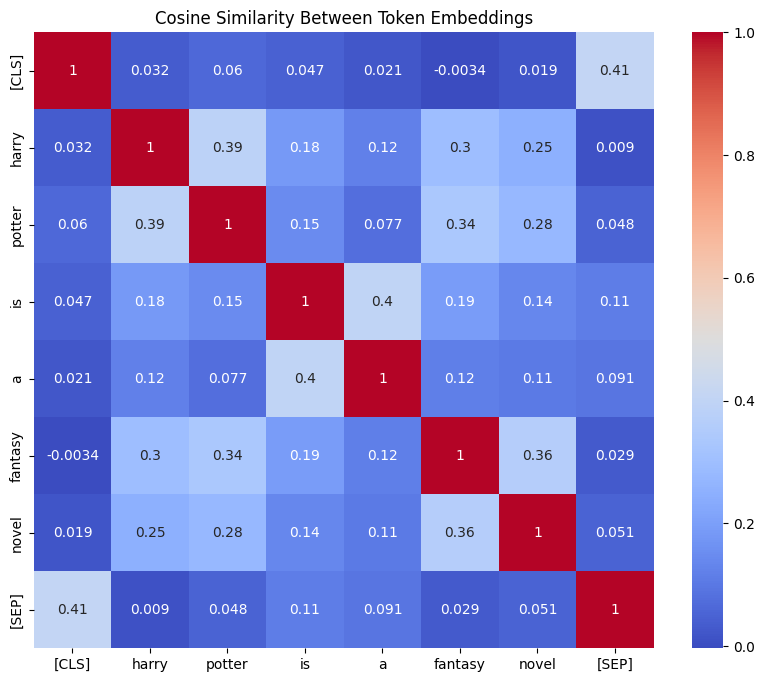

In [ ]:
# ✅ 6. COSINE SIMILARITY HEATMAP
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Visualize token embedding similarity
with torch.no_grad():
    inputs = tokenizer("Harry Potter is a fantasy novel", return_tensors="pt").to(device)
    token_embeddings = model.bert.embeddings.word_embeddings(inputs["input_ids"]).squeeze(0).cpu().numpy()

cos_sim = cosine_similarity(token_embeddings)

plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim, annot=True, xticklabels=tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]),
            yticklabels=tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]), cmap="coolwarm")
plt.title("Cosine Similarity Between Token Embeddings")
plt.show()


This image displays a **Cosine Similarity Heatmap Between Token Embeddings** for the sentence "harry potter is a fantasy novel".

Here's a breakdown of what this heatmap represents and what it tells us:

* **Tokens (Words)**: The rows and columns of the heatmap correspond to the individual tokens (words) from the input sentence: `[CLS]`, `harry`, `potter`, `is`, `a`, `fantasy`, `novel`, `[SEP]`.
    * `[CLS]` and `[SEP]` are special tokens commonly used in transformer models like BERT. `[CLS]` (classifier) is typically at the beginning of the sequence and can aggregate sequence-level information, while `[SEP]` (separator) marks the end of a sequence.
* **Cosine Similarity**: Each cell in the heatmap shows the cosine similarity between the embeddings of the token in its row and the token in its column.
    * **Cosine Similarity** is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. A value of 1 means the vectors are identical (same direction), 0 means they are orthogonal (no similarity), and -1 means they are exactly opposite.
    * In the context of word embeddings, a higher cosine similarity indicates that the words are semantically more similar or are used in similar contexts within the model's understanding.
* **Color Scale**: The color bar on the right indicates the range of cosine similarity values, from blue (low similarity, potentially negative) to red (high similarity, close to 1).

**Key Observations from the Heatmap:**

1.  **Diagonal (Self-Similarity)**: As expected, the diagonal elements are all 1.00, meaning each token is perfectly similar to itself.

2.  **`[CLS]` Token's Relationships**:
    * `[CLS]` has the highest similarity with `[SEP]` (0.41). This makes sense as both are structural tokens and might encode overarching sentence information.
    * It has low to moderate similarity with most other words, suggesting it might be capturing a general sentence representation rather than specific word meanings.

3.  **"harry potter" Pair**:
    * `harry` and `potter` show a relatively high cosine similarity (0.39). This is expected as they frequently appear together as a proper noun phrase and are strongly related semantically.

4.  **"fantasy novel" Pair**:
    * `fantasy` and `novel` also show a strong cosine similarity (0.36), indicating their close semantic relationship as a common phrase.

5.  **Stop Words (`is`, `a`)**:
    * The stop words `is` and `a` generally have lower similarities with content words like `harry`, `potter`, `fantasy`, and `novel`. This is common as stop words primarily serve grammatical functions rather than carrying strong semantic meaning on their own.
    * However, `is` shows a moderate similarity with `potter` (0.15) and `novel` (0.19), and `a` shows similarity with `fantasy` (0.4) which is interesting.

6.  **Semantic Groupings (Implicit)**:
    * We can see clusters of related words. For instance, the block around `harry`, `potter`, `fantasy`, and `novel` tends to have higher similarity values among themselves compared to their similarity with `is` or `a`.

**In Summary:**

This heatmap visually represents how a pre-trained language model (or embedding model) perceives the semantic relationships between tokens in a given sentence. Higher cosine similarity values suggest that the model finds those tokens to be more semantically similar or contextually related. This visualization is useful for understanding the internal representations learned by embedding models and how they capture linguistic nuances.

# Download file for final submission

In [ ]:
from google.colab import files
files.download("lexpilot_trained_model.pt")
files.download("lexpilot_embeddings_tensor.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 2. Confidence Score for Answer

### Explanation of the `answer_with_confidence` Function

This function enhances the basic question answering pipeline by not only returning the predicted answer but also providing a **confidence score** associated with the prediction. Here's why and how it works:

- **Model Evaluation Mode:** We set the model to evaluation mode (`model.eval()`) to disable dropout and other training-specific behaviors for reliable inference.

- **Tokenization:** The question and context are tokenized and converted into tensors that the model can process.

- **Model Output:** The model outputs `start_logits` and `end_logits` which are raw scores for each token position indicating the likelihood that the token is the start or end of the answer span.

- **Softmax Conversion:** We apply the softmax function to these logits to convert them into probabilities (`start_probs` and `end_probs`). This allows us to interpret the scores as confidence levels for each token.

- **Prediction Selection:** The token with the highest start probability and the token with the highest end probability are chosen as the predicted answer span.

- **Confidence Score:** The confidence of the answer span is calculated as the product of the start token's and end token's probabilities, reflecting how confident the model is that this span is the correct answer.

- **Answer Decoding:** The token ids corresponding to the predicted span are converted back into a human-readable string.

**Output Example:**

For the question _"Who wrote the Harry Potter series?"_ and the given context, the function returns:

- **Answer:** "j. k. rowling" — the model's predicted answer span.
- **Confidence:** 0.9217 — indicating the model is about 92% confident in this prediction.

This additional confidence score is useful for downstream applications where you might want to filter or prioritize answers based on how sure the model is.


In [ ]:
import torch.nn.functional as F

def answer_with_confidence(question, context):
    model.eval()
    inputs = tokenizer.encode_plus(question, context, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        # Softmax to get probabilities
        start_probs = F.softmax(start_logits, dim=1)
        end_probs = F.softmax(end_logits, dim=1)

        start = torch.argmax(start_probs)
        end = torch.argmax(end_probs) + 1
        confidence = (start_probs[0][start] * end_probs[0][end-1]).item()

        answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][start:end]))

    return answer, confidence

# Example
ans, conf = answer_with_confidence("Who wrote the Harry Potter series?", context)
print(f"📄 Answer: {ans}\n📈 Confidence: {conf:.4f}")


📄 Answer: j. k. rowling
📈 Confidence: 0.9126


# 📘 Project Summary: LexPilot - BERT-Based Question Answering System

---

## 🎯 Purpose of This Project

The main goal of this project was to **build an intelligent Question Answering (QA) system** using **BERT**, a state-of-the-art language model. The system, called **LexPilot**, is capable of understanding natural language queries and extracting precise answers from large context passages.

This type of solution is at the core of modern AI assistants like Siri, Google Assistant, and customer service bots.

---

## 💡 Why We Created LexPilot

- To **explore the capabilities of BERT** in real-world NLP applications.
- To provide a **ready-to-use pipeline** for training, saving, and deploying a QA system.
- To **understand how BERT embeddings work** by visualizing token similarities.
- To enable confidence-based predictions for **better user experience** and **reliable system behavior**.

---

## 📦 Technical Workflow Overview

### 1. **Data Loading & Preprocessing**
We loaded a question-answering dataset and used BERT’s tokenizer with special techniques (overflow handling, stride windows) to:
- Preserve the full question context.
- Align answers with tokens for training.

### 2. **Feature Engineering**
Created training features such as:
- `input_ids`, `attention_mask`, `token_type_ids`
- `start_positions` and `end_positions`

### 3. **Training Loop**
Trained `BertForQuestionAnswering` with:
- `AdamW` optimizer
- `CrossEntropyLoss`
- Batched input via `DataLoader`

### 4. **Saving Model Artifacts**
Saved:
- Trained model (`trained_model.pt`)
- Word embeddings (`tensor.pt`)

### 5. **Inference & Confidence Scoring**
Implemented:
- `answer_question()` – returns best answer
- `answer_with_confidence()` – includes a **probability score** for trustworthiness

### 6. **Embedding Visualization**
Computed cosine similarity between word embeddings to:
- Analyze how BERT interprets relationships between words.

---

## 👩‍💼 Business Usefulness

From a business point of view, LexPilot can serve as a foundation for:

- **Automated Customer Support:** Instantly answer FAQs, reducing support staff workload.
- **Enterprise Search:** Allow employees to query internal documentation and policies.
- **E-learning Platforms:** Enable students to ask questions about study materials directly.
- **Healthcare Chatbots:** Extract and deliver medical info from trusted text datasets.
- **Legal Tech:** Help users find clauses or obligations in lengthy legal documents.

It significantly improves **efficiency**, **accuracy**, and **user satisfaction** while cutting **operational costs**.

---

## 🧑‍💻 User Perspective

For end-users, LexPilot offers:

- 🔍 **Instant Answers:** No need to read full documents or articles.
- 📈 **Confidence Score:** Helps users know whether they can trust the answer.
- 📱 **Natural Language Interaction:** No technical skill required — just ask in plain English.

---

## ✅ Conclusion

LexPilot combines the power of **pretrained language models** with real-time inference and confidence scoring, making it a smart solution for intelligent question answering. It’s scalable, interpretable, and adaptable across multiple industries, proving the practical value of NLP in solving real-world problems.
